In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Read data

In [2]:
!git clone https://github.com/andrsolo21/hse_ML_intro

Cloning into 'hse_ML_intro'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [3]:
!ls

hse_ML_intro  sample_data


In [4]:
columns = ["date", "time", "open","max","min", "close", "volume"]
df = pd.read_csv("hse_ML_intro/data/EURUSD_30_2020-10-01_2020-10-31.csv", names = columns)

df["average"] = (df["max"] + df["min"]) / 2
df["datetime"] = df["date"] + "@" +  df["time"]
df["datetime"] = df["datetime"].apply(lambda x: datetime.strptime(x,"%Y.%m.%d@%H:%M"))

In [5]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1018 non-null   object        
 1   time      1018 non-null   object        
 2   open      1018 non-null   float64       
 3   max       1018 non-null   float64       
 4   min       1018 non-null   float64       
 5   close     1018 non-null   float64       
 6   volume    1018 non-null   int64         
 7   average   1018 non-null   float64       
 8   datetime  1018 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 71.7+ KB
None


,date,time,open,max,min,close,volume,average,datetime
0,2020.10.01,00:00,1.1721,1.1725,1.1720,1.1722,31,1.17225,2020-10-01 00:00:00
1,2020.10.01,00:30,1.1723,1.1726,1.1719,1.1723,44,1.17225,2020-10-01 00:30:00
2,2020.10.01,01:30,1.1730,1.1730,1.1728,1.1729,72,1.17290,2020-10-01 01:30:00
3,2020.10.01,02:00,1.1728,1.1731,1.1726,1.1729,80,1.17285,2020-10-01 02:00:00
4,2020.10.01,02:30,1.1728,1.1728,1.1722,1.1723,54,1.17250,2020-10-01 02:30:00


# Calc mov average

In [6]:
delta = df.iloc[4]["datetime"] - df.iloc[3]["datetime"]
count = 286

prdf = df[["datetime"]].copy()
prdf["datetime"] = prdf["datetime"] + 286 * delta
prdf["movaverage"] = 0
for i in range(df.shape[0]):
    prdf["movaverage"].iloc[i]= df.iloc[i:143 + i]["average"].mean()
print(prdf[prdf["movaverage"] == 0].shape)
print(delta)
prdf.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(0, 2)
0 days 00:30:00


,datetime,movaverage
0,2020-10-06 23:00:00,1.173700
1,2020-10-06 23:30:00,1.173741
2,2020-10-07 00:30:00,1.173784
3,2020-10-07 01:00:00,1.173824
4,2020-10-07 01:30:00,1.173863


# Forecast

In [7]:
from fbprophet import Prophet

In [8]:
m = Prophet()

In [9]:
data = pd.DataFrame()
data['ds'] = df['datetime']
data['y'] = df['average']
m.fit(data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [10]:
future = pd.DataFrame()
future['ds'] = prdf["datetime"]
forecast = m.predict(future)

In [12]:
prdf2 = prdf.merge(forecast[["ds","yhat"]], left_on = "datetime",right_on = "ds", how = "left")

# Print graphs

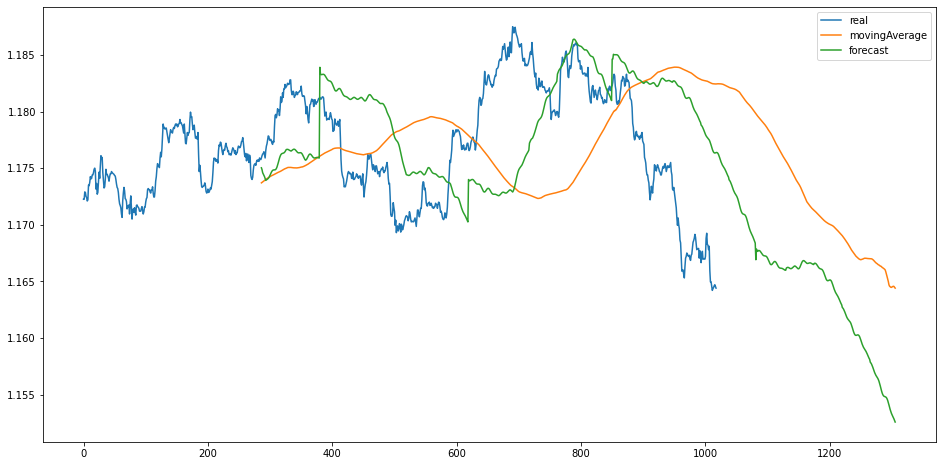

In [13]:

plt.figure(figsize=(16,8))
realx = np.arange(df.shape[0])
plt.plot(realx,df["average"], label = "real")

movx = np.arange(prdf2.shape[0]) + 286
plt.plot(movx,prdf2["movaverage"], label = "movingAverage")

plt.plot(movx,prdf2["yhat"], label = "forecast")

plt.legend()
plt.show()

# quality

In [14]:
res = df.merge(prdf2, on = "datetime", how = "outer", indicator = True)

In [15]:
resB = res[res["_merge"] == "both"]

In [16]:
resMov = np.mean(np.abs(resB["average"] - resB["movaverage"])) * (timedelta(hours = 24) / delta) / resB["average"].iloc[0]
resFor = np.mean(np.abs(resB["average"] - resB["yhat"])) * (timedelta(hours = 24) / delta) / resB["average"].iloc[0]
print("moving average result: ", resMov)
print("forecast result: ", resFor)

moving average result:  0.19860035448966745
forecast result:  0.04064732883456679


In [17]:
resB["average"].iloc[0]

1.17465

In [18]:
(timedelta(hours = 24) / delta)

48.0